# MMAE 350 Homework: Direct Solvers, LU, and Performance with Numba

This notebook is a **ready-to-run template** for the homework.  
Fill in the **TODO** sections and run the experiments.

## Learning objectives
By completing this assignment, you will be able to:
1. Implement **Gaussian elimination** and **LU factorization** for dense linear systems.
2. Compare accuracy and runtime against `numpy.linalg.solve`.
3. Use **Numba JIT** to accelerate loop-based numerical code.
4. Interpret scaling trends with problem size.

## Important notes

- We will generate **symmetric positive definite (SPD)** matrices to avoid pivoting issues:

  \begin{equation}
  A = B^T B + \alpha I,\qquad \alpha=1.
  \end{equation}

- **Do not** try to speed up `numpy.linalg.solve` with Numba. That routine is already compiled and optimized.
- When timing Numba code, you must **warm up once** to exclude compilation time.

In [18]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd



# Optional (Part D)
try:
    import numba as nb
    NUMBA_AVAILABLE = True
except ImportError:
    NUMBA_AVAILABLE = False

print("Numba available:", NUMBA_AVAILABLE)

Numba available: True


## Part A — Generate test systems

We will test sizes:

\begin{equation}
n \in \{100,\;200,\;300,\;400\}
\end{equation}

You may adjust these if your machine is too slow.

In [19]:
def make_spd_system(n, seed=0, alpha=1.0):
    """Create SPD matrix A = B^T B + alpha*I and random b."""
    rng = np.random.default_rng(seed)
    B = rng.standard_normal((n, n))
    A = B.T @ B + alpha * np.eye(n)
    b = rng.standard_normal(n)
    return A, b

def rel_error(x, x_ref):
    return np.linalg.norm(x - x_ref) / np.linalg.norm(x_ref)

def time_function(func, *args, repeats=3):
    """Time func(*args). Return (best_time, output), where best_time is min over repeats."""
    best = float("inf")
    out = None
    for _ in range(repeats):
        t0 = time.perf_counter()
        out = func(*args)
        t1 = time.perf_counter()
        best = min(best, t1 - t0)
    return best, out

## Part B — Implement solvers (pure Python)

### B1. Back and forward substitution

These are used both for Gaussian elimination and LU solves.

In [20]:
def back_substitution(U, b):
    """Solve Ux=b for upper triangular U."""
    n = b.shape[0]
    x = np.zeros_like(b, dtype=np.float64)
    for i in range(n-1, -1, -1):
        s = 0.0
        for j in range(i+1, n):
            s += U[i, j] * x[j]
        x[i] = (b[i] - s) / U[i, i]
    return x

def forward_substitution(L, b):
    """Solve Ly=b for lower triangular L with nonzero diagonal."""
    n = b.shape[0]
    y = np.zeros_like(b, dtype=np.float64)
    for i in range(n):
        s = 0.0
        for j in range(i):
            s += L[i, j] * y[j]
        y[i] = (b[i] - s) / L[i, i]
    return y

### B2. Gaussian elimination (no pivoting)

Implement forward elimination + back substitution.

**Tip:** Work on copies of `A` and `b` so the originals are not overwritten.

In [21]:
def gauss_elimination_solve(A, b):
    """Gaussian elimination without pivoting. Returns x."""
    A = A.copy().astype(np.float64)
    b = b.copy().astype(np.float64)
    n = b.shape[0]

    # Forward elimination
    for k in range(n-1):
        pivot = A[k, k]
        for i in range(k+1, n):
            m = A[i, k] / pivot
            A[i, k] = 0.0
            for j in range(k+1, n):
                A[i, j] -= m * A[k, j]
            b[i] -= m * b[k]

    # Back substitution
    x = back_substitution(A, b)
    return x

### B3. LU factorization

Implement factorization $\mathbf{A} = \mathbf{L}\mathbf{U}$ where $\mathbf{L}$ has ones on the diagonal.
Then solve using forward/back substitution.

In [22]:
def lu_factor(A):
    """LU factorization: A = L U. L has ones on diagonal."""
    A = A.copy().astype(np.float64)
    n = A.shape[0]
    L = np.eye(n, dtype=np.float64)
    U = np.zeros((n, n), dtype=np.float64)

    for k in range(n):
        # Compute U[k, k:n]
        for j in range(k, n):
            s = 0.0
            for p in range(k):
                s += L[k, p] * U[p, j]
            U[k, j] = A[k, j] - s

        # Compute L[k+1:n, k]
        for i in range(k+1, n):
            s = 0.0
            for p in range(k):
                s += L[i, p] * U[p, k]
            L[i, k] = (A[i, k] - s) / U[k, k]

    return L, U

def lu_solve(L, U, b):
    y = forward_substitution(L, b)
    x = back_substitution(U, y)
    return x

## Sanity check (small system)

Run this once to verify correctness before doing timings.

In [23]:
# Small test
A, b = make_spd_system(5, seed=0, alpha=1.0)
x_ref = np.linalg.solve(A, b)

x_ge = gauss_elimination_solve(A, b)
L, U = lu_factor(A)
x_lu = lu_solve(L, U, b)

print("rel error (GE):", rel_error(x_ge, x_ref))
print("rel error (LU):", rel_error(x_lu, x_ref))

rel error (GE): 3.850663051072461e-16
rel error (LU): 4.3389009513194307e-16


In [24]:
print(np.array(A))

[[ 2.08776677  0.65205813  2.18922943 -0.45151564 -0.62790124]
 [ 0.65205813  4.88301591  0.31749148 -0.68427832 -0.96367188]
 [ 2.18922943  0.31749148  8.25540137 -0.45463791  0.42453922]
 [-0.45151564 -0.68427832 -0.45463791  1.84711614  1.85363403]
 [-0.62790124 -0.96367188  0.42453922  1.85363403  6.34361976]]


In [25]:
b

array([ 0.0940123 , -0.74349925, -0.92172538, -0.45772583,  0.22019512])

In [26]:
A-L@U

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.22044605e-16,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.55111512e-17,
         0.00000000e+00, -8.88178420e-16]])

## Part C — Timing (pure Python)

For each size \(n\), time:
- your Gaussian elimination
- your LU (factor + solve)
- NumPy `np.linalg.solve`

We report the **minimum** of 3 repeats.

In [27]:
def run_experiment_python(ns=(50, 100, 150, 200), seed=0):
    results = []
    for n in ns:
        A, b = make_spd_system(n, seed=seed, alpha=1.0)
        x_ref = np.linalg.solve(A, b)

        t_ge, x_ge = time_function(gauss_elimination_solve, A, b, repeats=3)
        err_ge = rel_error(x_ge, x_ref)

        t_lu_fact, (L, U) = time_function(lu_factor, A, repeats=3)
        t_lu_solve, x_lu = time_function(lu_solve, L, U, b, repeats=3)
        t_lu_total = t_lu_fact + t_lu_solve
        err_lu = rel_error(x_lu, x_ref)

        t_np, x_np = time_function(np.linalg.solve, A, b, repeats=3)
        err_np = rel_error(x_np, x_ref)

        results.append({
            "n": n,
            "t_ge_py": t_ge,
            "t_lu_py": t_lu_total,
            "t_np": t_np,
            "err_ge_py": err_ge,
            "err_lu_py": err_lu,
            "err_np": err_np,
        })

        print(f"n={n:4d} | GE_py={t_ge:.3f}s | LU_py={t_lu_total:.3f}s | np={t_np:.3f}s")

    return results

# TODO: run this cell when ready (may take some time at larger n).
# results_py = run_experiment_python()

## Part D — Numba acceleration

Numba can JIT-compile your **loop-based** routines to machine code.

**Warm-up rule:** The first call compiles. Always do one call before timing.

In [28]:
if NUMBA_AVAILABLE:
    nb_njit = nb.njit

    @nb_njit
    def back_substitution_nb(U, b):
        n = b.shape[0]
        x = np.zeros(n, dtype=np.float64)
        for i in range(n-1, -1, -1):
            s = 0.0
            for j in range(i+1, n):
                s += U[i, j] * x[j]
            x[i] = (b[i] - s) / U[i, i]
        return x

    @nb_njit
    def forward_substitution_nb(L, b):
        n = b.shape[0]
        y = np.zeros(n, dtype=np.float64)
        for i in range(n):
            s = 0.0
            for j in range(i):
                s += L[i, j] * y[j]
            y[i] = (b[i] - s) / L[i, i]
        return y

    @nb_njit
    def gauss_elimination_solve_nb(A_in, b_in):
        A = A_in.copy()
        b = b_in.copy()
        n = b.shape[0]
        for k in range(n-1):
            pivot = A[k, k]
            for i in range(k+1, n):
                m = A[i, k] / pivot
                A[i, k] = 0.0
                for j in range(k+1, n):
                    A[i, j] -= m * A[k, j]
                b[i] -= m * b[k]
        x = back_substitution_nb(A, b)
        return x

    @nb_njit
    def lu_factor_nb(A_in):
        A = A_in.copy()
        n = A.shape[0]
        L = np.eye(n, dtype=np.float64)
        U = np.zeros((n, n), dtype=np.float64)

        for k in range(n):
            for j in range(k, n):
                s = 0.0
                for p in range(k):
                    s += L[k, p] * U[p, j]
                U[k, j] = A[k, j] - s

            for i in range(k+1, n):
                s = 0.0
                for p in range(k):
                    s += L[i, p] * U[p, k]
                L[i, k] = (A[i, k] - s) / U[k, k]

        return L, U

    @nb_njit
    def lu_solve_nb(L, U, b):
        y = forward_substitution_nb(L, b)
        x = back_substitution_nb(U, y)
        return x
else:
    print("Numba not available. Skip Part D.")

In [29]:
def run_experiment_numba(ns=(50, 100, 150, 200), seed=0):
    if not NUMBA_AVAILABLE:
        raise RuntimeError("Numba not installed in this environment.")
    results = []
    for n in ns:
        A, b = make_spd_system(n, seed=seed, alpha=1.0)
        x_ref = np.linalg.solve(A, b)

        # Warm-up compile (not timed)
        _ = gauss_elimination_solve_nb(A, b)
        Lnb, Unb = lu_factor_nb(A)
        _ = lu_solve_nb(Lnb, Unb, b)

        t_ge_nb, x_ge_nb = time_function(gauss_elimination_solve_nb, A, b, repeats=3)
        err_ge_nb = rel_error(x_ge_nb, x_ref)

        t_lu_fact_nb, (Lnb, Unb) = time_function(lu_factor_nb, A, repeats=3)
        t_lu_solve_nb_t, x_lu_nb = time_function(lu_solve_nb, Lnb, Unb, b, repeats=3)
        t_lu_total_nb = t_lu_fact_nb + t_lu_solve_nb_t
        err_lu_nb = rel_error(x_lu_nb, x_ref)

        results.append({
            "n": n,
            "t_ge_nb": t_ge_nb,
            "t_lu_nb": t_lu_total_nb,
            "err_ge_nb": err_ge_nb,
            "err_lu_nb": err_lu_nb,
        })

        print(f"n={n:4d} | GE_nb={t_ge_nb:.3f}s | LU_nb={t_lu_total_nb:.3f}s")

    return results

# TODO: run this cell when ready
# results_nb = run_experiment_numba()

## Combine results and plot

After you run Parts C and D, combine results into a single table and plot runtime vs \(n\).

In [30]:
def combine_results(results_py, results_nb=None):
    by_n = {r["n"]: dict(r) for r in results_py}
    if results_nb is not None:
        for r in results_nb:
            by_n[r["n"]].update(r)
    return [by_n[n] for n in sorted(by_n.keys())]

In [31]:
def plot_timings(combined):
    ns = [r["n"] for r in combined]
    t_ge_py = [r["t_ge_py"] for r in combined]
    t_lu_py = [r["t_lu_py"] for r in combined]
    t_np    = [r["t_np"]    for r in combined]

    plt.figure()
    plt.plot(ns, t_ge_py, marker="o", label="GE (Python)")
    plt.plot(ns, t_lu_py, marker="o", label="LU (Python)")
    plt.plot(ns, t_np,    marker="o", label="NumPy solve")

    if "t_ge_nb" in combined[0] and combined[0]["t_ge_nb"] is not None:
        t_ge_nb = [r["t_ge_nb"] for r in combined]
        t_lu_nb = [r["t_lu_nb"] for r in combined]
        plt.plot(ns, t_ge_nb, marker="o", label="GE (Numba)")
        plt.plot(ns, t_lu_nb, marker="o", label="LU (Numba)")

    plt.xlabel("System size n")
    plt.ylabel("Time (s)")
    #plt.xscale("log")
    #plt.yscale("log")
    plt.grid(True, which="both")
    plt.legend()
    plt.title("Runtime vs system size (log-log)")
    plt.show()

# Example usage:
# combined = combine_results(results_py, results_nb if NUMBA_AVAILABLE else None)
# plot_timings(combined)

## Run experiements and plot/interpret results

Note that the cell just before the short-answer questions stores the results in a dataframe and displays that dataframe. Recall we can use df.to_csv('name.csv') to output the dataframe as a csv file into our working directory.


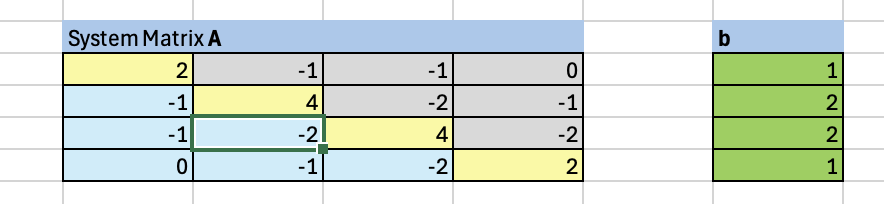

In [32]:
A = np.array([[2,-1,-1,0],[-1,4,-2,-1],[-1,2,4,-2],[0,-1,-2,2]])

In [34]:
A

array([[ 2, -1, -1,  0],
       [-1,  4, -2, -1],
       [-1,  2,  4, -2],
       [ 0, -1, -2,  2]])

In [35]:
L,U = lu_factor(A)

In [36]:
np.array(L)

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [-0.5       ,  1.        ,  0.        ,  0.        ],
       [-0.5       ,  0.42857143,  1.        ,  0.        ],
       [ 0.        , -0.28571429, -0.59375   ,  1.        ]])

In [37]:
np.array(U)

array([[ 2.        , -1.        , -1.        ,  0.        ],
       [ 0.        ,  3.5       , -2.5       , -1.        ],
       [ 0.        ,  0.        ,  4.57142857, -1.57142857],
       [ 0.        ,  0.        ,  0.        ,  0.78125   ]])

In [38]:
np.dot(L,U)

array([[ 2., -1., -1.,  0.],
       [-1.,  4., -2., -1.],
       [-1.,  2.,  4., -2.],
       [ 0., -1., -2.,  2.]])

In [39]:
L@U

array([[ 2., -1., -1.,  0.],
       [-1.,  4., -2., -1.],
       [-1.,  2.,  4., -2.],
       [ 0., -1., -2.,  2.]])

In [40]:
results_py = run_experiment_python()

n=  50 | GE_py=0.013s | LU_py=0.008s | np=0.000s
n= 100 | GE_py=0.049s | LU_py=0.043s | np=0.000s
n= 150 | GE_py=0.167s | LU_py=0.145s | np=0.000s
n= 200 | GE_py=0.403s | LU_py=0.345s | np=0.000s


In [41]:
results_py

[{'n': 50,
  't_ge_py': 0.013434000000415836,
  't_lu_py': 0.007610833003127482,
  't_np': 1.8083002942148596e-05,
  'err_ge_py': np.float64(2.458117595827267e-15),
  'err_lu_py': np.float64(4.832647338947111e-15),
  'err_np': np.float64(0.0)},
 {'n': 100,
  't_ge_py': 0.049368457999662496,
  't_lu_py': 0.043168709009478334,
  't_np': 4.245799937052652e-05,
  'err_ge_py': np.float64(4.626108620174643e-15),
  'err_lu_py': np.float64(7.56298578311008e-15),
  'err_np': np.float64(0.0)},
 {'n': 150,
  't_ge_py': 0.16722624999965774,
  't_lu_py': 0.14530179199937265,
  't_np': 8.00420020823367e-05,
  'err_ge_py': np.float64(8.51144521540756e-15),
  'err_lu_py': np.float64(1.6641755143969518e-14),
  'err_np': np.float64(0.0)},
 {'n': 200,
  't_ge_py': 0.4030879999991157,
  't_lu_py': 0.34461345699673984,
  't_np': 0.00011754099978134036,
  'err_ge_py': np.float64(2.1407419310013435e-14),
  'err_lu_py': np.float64(2.199642329220055e-14),
  'err_np': np.float64(0.0)}]

In [42]:
type(results_py)

list

In [43]:
df = pd.DataFrame(results_py)

In [44]:
df

,n,t_ge_py,t_lu_py,t_np,err_ge_py,err_lu_py,err_np
0,50,0.013434,0.007611,0.000018,2.458118e-15,4.832647e-15,0.0
1,100,0.049368,0.043169,0.000042,4.626109e-15,7.562986e-15,0.0
2,150,0.167226,0.145302,0.000080,8.511445e-15,1.664176e-14,0.0
3,200,0.403088,0.344613,0.000118,2.140742e-14,2.199642e-14,0.0


In [45]:
df.to_csv('something.csv')

In [46]:
df.loc[0,'n']

np.int64(50)

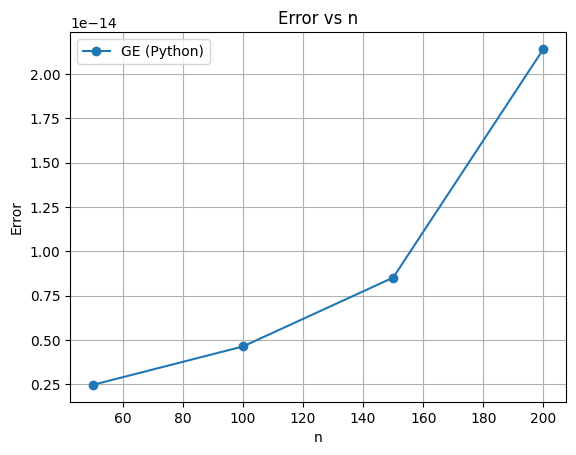

In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["n"], df["err_ge_py"], marker="o", label="GE (Python)")
plt.xlabel("n")
plt.ylabel("Error")
plt.title("Error vs n")
plt.legend()
plt.grid(True)
plt.show()

In [48]:
results_nb = run_experiment_numba()

n=  50 | GE_nb=0.000s | LU_nb=0.000s
n= 100 | GE_nb=0.000s | LU_nb=0.000s
n= 150 | GE_nb=0.000s | LU_nb=0.000s
n= 200 | GE_nb=0.001s | LU_nb=0.001s


In [49]:
combined = combine_results(results_py, results_nb)

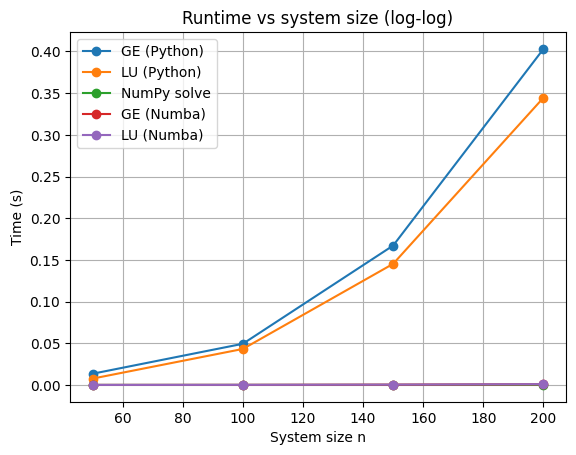

In [50]:
plot_timings(combined)

In [86]:
type(combined)

list

In [87]:
df_combined = pd.DataFrame(combined)

In [88]:
df_combined

,n,t_ge_py,t_lu_py,t_np,err_ge_py,err_lu_py,err_np,t_ge_nb,t_lu_nb,err_ge_nb,err_lu_nb
0,50,0.012075,0.007333,0.000018,2.458118e-15,4.832647e-15,0.0,0.000037,0.000096,2.458118e-15,4.832647e-15
1,100,0.049433,0.041921,0.000045,4.626109e-15,7.562986e-15,0.0,0.000777,0.000622,4.626109e-15,7.562986e-15
2,150,0.163049,0.144197,0.000083,8.511445e-15,1.664176e-14,0.0,0.001078,0.001175,8.511445e-15,1.664176e-14
3,200,0.392688,0.338033,0.000118,2.140742e-14,2.199642e-14,0.0,0.002234,0.002256,2.140742e-14,2.199642e-14


In [89]:
#df = pd.DataFrame(combined)
#df

## Short-answer questions (include in your submission)

Answer each in **3–6 sentences**:

1. Why does Numba not speed up `numpy.linalg.solve`?
2. Why do loop-based solvers benefit from Numba?
3. Which method scales best in your results, and why?
4. What practical limitations appear as \(n\) increases?